In [12]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [14]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn
Cp

5.795692012196613

## Initialize model at full charge to 4.1V

In [3]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-15,
    "SEI resistivity [Ohm.m]": 0,
})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [4]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 2.5
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.9045382294223173
0.26790266184827943


## One cycle

In [5]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

In [6]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.6147752325586207, step=0.03614775232558621…

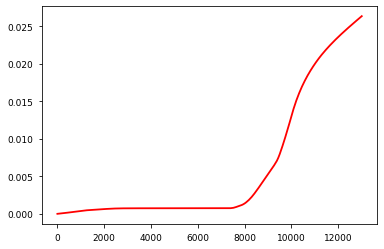

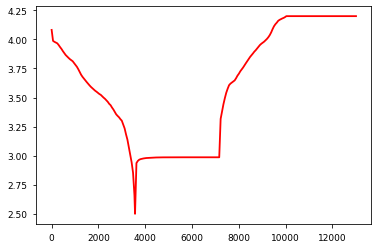

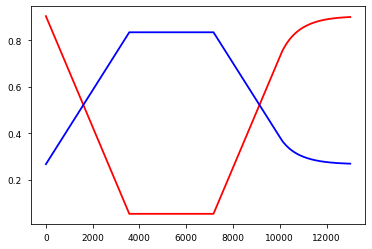

In [7]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [8]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## Several cycles

In [9]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 173,
termination="80% capacity"
)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
spm_sol_100 = sim_100.solve()

2021-03-21 18:53:06,206 - [NOTICE] simulation.solve(701): Cycle 1/173 (27.618 ms elapsed) --------------------
2021-03-21 18:53:06,207 - [NOTICE] simulation.solve(731): Cycle 1/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:06,367 - [NOTICE] simulation.solve(731): Cycle 1/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:06,509 - [NOTICE] simulation.solve(731): Cycle 1/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:06,655 - [NOTICE] simulation.solve(731): Cycle 1/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:07,045 - [NOTICE] simulation.solve(807): Capacity is now 5.093 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:07,046 - [NOTICE] simulation.solve(701): Cycle 2/173 (867.297 ms elapsed) --------------------
2021-03-21 18:53:07,046 - [NOTICE] simulation.solve(731): Cycle 2/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:07,174 - [NOTICE] simulation.solve(731): Cycle 2/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:07,284 - [NO

2021-03-21 18:53:13,661 - [NOTICE] simulation.solve(731): Cycle 13/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:13,894 - [NOTICE] simulation.solve(807): Capacity is now 5.074 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:13,895 - [NOTICE] simulation.solve(701): Cycle 14/173 (7.716 s elapsed) --------------------
2021-03-21 18:53:13,895 - [NOTICE] simulation.solve(731): Cycle 14/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:14,032 - [NOTICE] simulation.solve(731): Cycle 14/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:14,149 - [NOTICE] simulation.solve(731): Cycle 14/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:14,248 - [NOTICE] simulation.solve(731): Cycle 14/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:14,453 - [NOTICE] simulation.solve(807): Capacity is now 5.072 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:14,454 - [NOTICE] simulation.solve(701): Cycle 15/173 (8.275 s elapsed) --------------------

2021-03-21 18:53:20,845 - [NOTICE] simulation.solve(731): Cycle 26/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:20,973 - [NOTICE] simulation.solve(731): Cycle 26/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:21,094 - [NOTICE] simulation.solve(731): Cycle 26/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:21,204 - [NOTICE] simulation.solve(731): Cycle 26/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:21,404 - [NOTICE] simulation.solve(807): Capacity is now 5.052 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:21,405 - [NOTICE] simulation.solve(701): Cycle 27/173 (15.226 s elapsed) --------------------
2021-03-21 18:53:21,406 - [NOTICE] simulation.solve(731): Cycle 27/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:21,527 - [NOTICE] simulation.solve(731): Cycle 27/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:21,634 - [NOTICE] simulation.solve(731): Cycle 27/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:21,735 - [NO

2021-03-21 18:53:28,186 - [NOTICE] simulation.solve(731): Cycle 38/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:28,367 - [NOTICE] simulation.solve(807): Capacity is now 5.030 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:28,368 - [NOTICE] simulation.solve(701): Cycle 39/173 (22.189 s elapsed) --------------------
2021-03-21 18:53:28,368 - [NOTICE] simulation.solve(731): Cycle 39/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:28,559 - [NOTICE] simulation.solve(731): Cycle 39/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:28,708 - [NOTICE] simulation.solve(731): Cycle 39/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:28,831 - [NOTICE] simulation.solve(731): Cycle 39/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:29,065 - [NOTICE] simulation.solve(807): Capacity is now 5.029 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:29,065 - [NOTICE] simulation.solve(701): Cycle 40/173 (22.887 s elapsed) ------------------

2021-03-21 18:53:34,898 - [NOTICE] simulation.solve(731): Cycle 51/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:35,038 - [NOTICE] simulation.solve(731): Cycle 51/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:35,152 - [NOTICE] simulation.solve(731): Cycle 51/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:35,258 - [NOTICE] simulation.solve(731): Cycle 51/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:35,479 - [NOTICE] simulation.solve(807): Capacity is now 5.007 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:35,480 - [NOTICE] simulation.solve(701): Cycle 52/173 (29.301 s elapsed) --------------------
2021-03-21 18:53:35,482 - [NOTICE] simulation.solve(731): Cycle 52/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:35,603 - [NOTICE] simulation.solve(731): Cycle 52/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:35,710 - [NOTICE] simulation.solve(731): Cycle 52/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:35,824 - [NO

2021-03-21 18:53:42,272 - [NOTICE] simulation.solve(731): Cycle 63/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:42,487 - [NOTICE] simulation.solve(807): Capacity is now 4.986 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:42,488 - [NOTICE] simulation.solve(701): Cycle 64/173 (36.309 s elapsed) --------------------
2021-03-21 18:53:42,489 - [NOTICE] simulation.solve(731): Cycle 64/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:42,617 - [NOTICE] simulation.solve(731): Cycle 64/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:42,740 - [NOTICE] simulation.solve(731): Cycle 64/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:42,843 - [NOTICE] simulation.solve(731): Cycle 64/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:43,033 - [NOTICE] simulation.solve(807): Capacity is now 4.985 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:43,034 - [NOTICE] simulation.solve(701): Cycle 65/173 (36.855 s elapsed) ------------------

2021-03-21 18:53:48,892 - [NOTICE] simulation.solve(731): Cycle 76/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:49,015 - [NOTICE] simulation.solve(731): Cycle 76/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:49,131 - [NOTICE] simulation.solve(731): Cycle 76/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:49,231 - [NOTICE] simulation.solve(731): Cycle 76/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:49,454 - [NOTICE] simulation.solve(807): Capacity is now 4.963 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:49,454 - [NOTICE] simulation.solve(701): Cycle 77/173 (43.275 s elapsed) --------------------
2021-03-21 18:53:49,455 - [NOTICE] simulation.solve(731): Cycle 77/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:49,576 - [NOTICE] simulation.solve(731): Cycle 77/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:49,709 - [NOTICE] simulation.solve(731): Cycle 77/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:49,826 - [NO

2021-03-21 18:53:56,221 - [NOTICE] simulation.solve(731): Cycle 88/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:56,407 - [NOTICE] simulation.solve(807): Capacity is now 4.943 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:56,408 - [NOTICE] simulation.solve(701): Cycle 89/173 (50.229 s elapsed) --------------------
2021-03-21 18:53:56,409 - [NOTICE] simulation.solve(731): Cycle 89/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:53:56,530 - [NOTICE] simulation.solve(731): Cycle 89/173, step 2/4: Rest for 1 hour
2021-03-21 18:53:56,643 - [NOTICE] simulation.solve(731): Cycle 89/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:53:56,738 - [NOTICE] simulation.solve(731): Cycle 89/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:53:56,933 - [NOTICE] simulation.solve(807): Capacity is now 4.941 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:53:56,934 - [NOTICE] simulation.solve(701): Cycle 90/173 (50.755 s elapsed) ------------------

2021-03-21 18:54:03,282 - [NOTICE] simulation.solve(731): Cycle 101/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:03,411 - [NOTICE] simulation.solve(731): Cycle 101/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:03,544 - [NOTICE] simulation.solve(731): Cycle 101/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:03,659 - [NOTICE] simulation.solve(731): Cycle 101/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:03,884 - [NOTICE] simulation.solve(807): Capacity is now 4.922 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:03,885 - [NOTICE] simulation.solve(701): Cycle 102/173 (57.706 s elapsed) --------------------
2021-03-21 18:54:03,885 - [NOTICE] simulation.solve(731): Cycle 102/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:04,004 - [NOTICE] simulation.solve(731): Cycle 102/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:04,127 - [NOTICE] simulation.solve(731): Cycle 102/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:04,2

2021-03-21 18:54:10,259 - [NOTICE] simulation.solve(731): Cycle 113/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:10,358 - [NOTICE] simulation.solve(731): Cycle 113/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:10,591 - [NOTICE] simulation.solve(807): Capacity is now 4.900 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:10,591 - [NOTICE] simulation.solve(701): Cycle 114/173 (1 minute, 4 seconds elapsed) --------------------
2021-03-21 18:54:10,592 - [NOTICE] simulation.solve(731): Cycle 114/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:10,714 - [NOTICE] simulation.solve(731): Cycle 114/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:10,846 - [NOTICE] simulation.solve(731): Cycle 114/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:10,960 - [NOTICE] simulation.solve(731): Cycle 114/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:11,207 - [NOTICE] simulation.solve(807): Capacity is now 4.899 Ah (originally 5.093 Ah, will st

2021-03-21 18:54:17,443 - [NOTICE] simulation.solve(731): Cycle 125/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:17,648 - [NOTICE] simulation.solve(807): Capacity is now 4.880 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:17,649 - [NOTICE] simulation.solve(701): Cycle 126/173 (1 minute, 11 seconds elapsed) --------------------
2021-03-21 18:54:17,649 - [NOTICE] simulation.solve(731): Cycle 126/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:17,764 - [NOTICE] simulation.solve(731): Cycle 126/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:17,879 - [NOTICE] simulation.solve(731): Cycle 126/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:17,977 - [NOTICE] simulation.solve(731): Cycle 126/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:18,175 - [NOTICE] simulation.solve(807): Capacity is now 4.879 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:18,176 - [NOTICE] simulation.solve(701): Cycle 127/173 (1 minute, 12 seco

2021-03-21 18:54:24,413 - [NOTICE] simulation.solve(807): Capacity is now 4.861 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:24,414 - [NOTICE] simulation.solve(701): Cycle 138/173 (1 minute, 18 seconds elapsed) --------------------
2021-03-21 18:54:24,414 - [NOTICE] simulation.solve(731): Cycle 138/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:24,535 - [NOTICE] simulation.solve(731): Cycle 138/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:24,649 - [NOTICE] simulation.solve(731): Cycle 138/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:24,760 - [NOTICE] simulation.solve(731): Cycle 138/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:24,957 - [NOTICE] simulation.solve(807): Capacity is now 4.859 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:24,958 - [NOTICE] simulation.solve(701): Cycle 139/173 (1 minute, 19 seconds elapsed) --------------------
2021-03-21 18:54:24,958 - [NOTICE] simulation.solve(731): Cycle 139/173, 

2021-03-21 18:54:31,459 - [NOTICE] simulation.solve(701): Cycle 150/173 (1 minute, 25 seconds elapsed) --------------------
2021-03-21 18:54:31,460 - [NOTICE] simulation.solve(731): Cycle 150/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:31,576 - [NOTICE] simulation.solve(731): Cycle 150/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:31,702 - [NOTICE] simulation.solve(731): Cycle 150/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:31,821 - [NOTICE] simulation.solve(731): Cycle 150/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:32,056 - [NOTICE] simulation.solve(807): Capacity is now 4.840 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:32,056 - [NOTICE] simulation.solve(701): Cycle 151/173 (1 minute, 26 seconds elapsed) --------------------
2021-03-21 18:54:32,057 - [NOTICE] simulation.solve(731): Cycle 151/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:32,171 - [NOTICE] simulation.solve(731): Cycle 151/173, step 2/4: Rest for

2021-03-21 18:54:38,397 - [NOTICE] simulation.solve(731): Cycle 162/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:38,510 - [NOTICE] simulation.solve(731): Cycle 162/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:38,620 - [NOTICE] simulation.solve(731): Cycle 162/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:38,721 - [NOTICE] simulation.solve(731): Cycle 162/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:54:38,927 - [NOTICE] simulation.solve(807): Capacity is now 4.821 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:54:38,928 - [NOTICE] simulation.solve(701): Cycle 163/173 (1 minute, 33 seconds elapsed) --------------------
2021-03-21 18:54:38,928 - [NOTICE] simulation.solve(731): Cycle 163/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:39,052 - [NOTICE] simulation.solve(731): Cycle 163/173, step 2/4: Rest for 1 hour
2021-03-21 18:54:39,169 - [NOTICE] simulation.solve(731): Cycle 163/173, step 3/4: Charge at 1C until 4.2V
2021-03-2

In [10]:
spm_sol_100

In [11]:
sim_100.solve(starting_solution=spm_sol_100)

2021-03-21 18:54:45,205 - [NOTICE] simulation.solve(701): Cycle 174/346 (40.379 ms elapsed) --------------------
2021-03-21 18:54:45,206 - [NOTICE] simulation.solve(731): Cycle 174/346, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:54:45,332 - [NOTICE] simulation.solve(731): Cycle 174/346, step 2/4: Rest for 1 hour
2021-03-21 18:54:45,465 - [NOTICE] simulation.solve(731): Cycle 174/346, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:54:45,576 - [NOTICE] simulation.solve(731): Cycle 174/346, step 4/4: Hold at 4.2V until C/50
CasADi - 2021-03-21 18:54:45 WARNING("roots:g failed: NaN detected for output x, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-21 18:54:45 WARNING("roots:jac_f_z failed: NaN detected for output x, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]


SolverError: Could not find acceptable solution: solver returned NaNs

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [ ]:
lli_100 = spm_sol_100["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

In [ ]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_100.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [ ]:
len(spm_sol_100.summary_variables.items())

In [ ]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_100.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_100.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [ ]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

Check how well extrapolating 1 cycle does

In [ ]:
n_cycles_step = 50
long_sol = spm_sol_100
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(long_sol.summary_variables["Cycle number"], long_sol.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(long_sol.cycles)-n_cycles_step:
    n_Li_cycle = long_sol.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,long_sol.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [ ]:
n_cycles_step = 60
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[-1] - n_Li_cycle[0]
    
    n_Li = n_Li_cycle_init + delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc.solution.first_state[var.name].data
            last = sim_acc.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step

In [ ]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(long_sol.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])

In [ ]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_acc],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims.eps", dpi=1000)

### Time upscaling

In [ ]:
n_cycles_step = 3
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_upscale = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_upscale = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_upscale.solve()
    
    for var in sol.all_models[0].initial_conditions:
        first = sim_upscale.solution.first_state[var.name].data
        last = sim_upscale.solution.last_state[var.name].data
        ics[var.name] = first + (last - first) * n_cycles_step
    sim_upscale.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)
    print(ics['X-averaged positive particle concentration'])
    cycle_nums.append(cycle)
    sol_upscale.append(sol)
    cycle += n_cycles_step

In [ ]:
sol_fast = sol_upscale
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()

It doesn't work because y_100 is much too non-linear, so extrapolating the change gives inaccurate results

### Linear extrapolation

In [ ]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
] * 2)
n_cycles_step = 60

sim_acc_linear = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc_linear = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate two cycles
    sol = sim_acc_linear.solve()
    
    n_Li_cycle_init = sol.cycles[-2].first_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_mid = sol.cycles[-2].last_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_last = sol.cycles[-1].last_state["Total lithium in particles [mol]"].data[0]

    delta_nLi_cycle_0 = n_Li_cycle_mid - n_Li_cycle_init
    delta_nLi_cycle_1 = n_Li_cycle_last - n_Li_cycle_mid
    delta_nLi_cycle_N = delta_nLi_cycle_0 + (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step
    
    # Linear extrapolation and integrate (triangle) to get the total n_li over cycles being stepped
#     delta_nLi_total = delta_nLi_cycle_0 + (n_cycles_step-1) * (delta_nLi_cycle_0 + delta_nLi_cycle_N) / 2
    delta_nLi_total = (
        delta_nLi_cycle_0 * n_cycles_step 
        + 1/2 * (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step * (n_cycles_step + 1)
    )
    n_Li = n_Li_cycle_init + delta_nLi_total

    print(n_Li_cycle_init)
    print(n_Li)
    print(n_Li_cycle_init + n_cycles_step * delta_nLi_cycle_0)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc_linear.solution.first_state[var.name].data
            last = sim_acc_linear.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc_linear.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc_linear.append(sol)
    cycle += n_cycles_step

In [ ]:
len(cycle_nums)

In [ ]:
sol_fast = sol_acc_linear
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name][0] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims_linear.eps", dpi=1000)